## Install (Colab Only)

In [1]:
# install
!pip install pyepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 413.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.7 MB/s eta 0:00:00


Remove the problematic hook from Google Colab.

In [2]:
import sys
sys.meta_path = [hook for hook in sys.meta_path if not any(keyword in str(hook) for keyword in ["google.colab"])]

# Knapsack Solution Visualization

We utilize a technique of visualizing predicted-then-optimized results in order to gain an intuitive understanding of the performance variations among the various approaches.

In this study, the knapsack problem is utilized as an exemplar.  The knapsack problem is a combinatorial optimization problem that seeks to find the most valuable set of items to include in a knapsack, subject to constraints on the total weight of the items.

## 1 Preparation

### 1.1 Libraries

Let's import useful libraries.

In [3]:
import time
import random
import pyepo
import torch
from matplotlib import pyplot as plt
from matplotlib import colormaps
import numpy as np
from tqdm import tqdm
from torch import nn

Auto-Sklearn cannot be imported.


Then, we set the random seed for reproducibility.

In [4]:
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

### 1.2 Visulization Function

Define a function that visualizes the result of the predict-then-optimize knapsack.

In [5]:
def visSol(data_loader, optmodel, ind=0, pytorch_model=None, method_name=None):
  # extract solutions by iterating over data loader (pytorch does not provide indexing into it)
  for i, data in enumerate(loader_test):
      if i == ind:
        # load data
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # convert to numpy
        c = c.to("cpu").detach().numpy()[0]
        w = w.to("cpu").detach().numpy()[0]
        z = z.to("cpu").detach().numpy()[0]
        # predict
        if pytorch_model is not None:
          cp = pytorch_model(x)
          cp = cp.to("cpu").detach().numpy()
          # solve
          optmodel.setObj(cp[0])
          wp, _ = optmodel.solve()
        else:
          cp = [None]
          wp = w
          method_name = "Groundtruth Optimal Solution"
        # plot
        fig = plotSol(m, c, wp, weights, caps, method_name, cp[0])
        break

In [6]:
# plot function
def plotSol(m, c, w, weights, caps, caption=None, cp=None):
    # colors
    cmap = colormaps["plasma"](np.linspace(0, 1, m))
    # get list
    sol, val, cap1, cap2, cpred = [], [], [], [], []
    for i in range(m):
        sol.append(3)
        val.append(c[i] * w[i])
        cap1.append(weights[0,i] * w[i])
        cap2.append(weights[1,i] * w[i])
        if cp is not None:
          cpred.append(cp[i] * w[i])
    # init fig
    fig = plt.figure(figsize=(8,4))
    plt.gca().invert_yaxis()
    acc = [0, 0, 0, 0]
    # bar plot
    if cp is None:
      for i in range(m):
          bar = [sol[i], val[i], cap1[i], cap2[i]]
          plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0, 0]
              plt.barh(range(4), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(4), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cap1[i], acc[3]+cap2[i]]
    else:
      acc = [0, 0, 0, 0, 0]
      for i in range(m):
          bar = [sol[i], val[i], cpred[i], cap1[i], cap2[i]]
          plt.barh(range(5), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
          # not selected
          if not int(w[i]):
              # grey color
              bar = [sol[i], 0, 0, 0, 0]
              plt.barh(range(5), bar, left=acc, color=cmap[i], height=0.75, edgecolor="w", linewidth=2)
              plt.barh(range(5), bar, left=acc, color="lightgrey", height=0.75, edgecolor="w", linewidth=2, alpha=0.9)
          acc = [acc[0]+sol[i], acc[1]+val[i], acc[2]+cpred[i], acc[3]+cap1[i], acc[4]+cap2[i]]
    # total value
    tval = sum(val)
    plt.text(tval+0.5, 1.1, tval, fontsize=12)
    # vertical line
    if cp is None:
      plt.axvline(x=caps[0], ymin=0.27, ymax=0.48, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 2.1, "Capacity 1", fontsize=12, color="firebrick")
      plt.axvline(x=caps[1], ymin=0.03, ymax=0.24, color="firebrick", linewidth=1.5)
      plt.text(caps[1]+0.5, 3.1, "Capacity 2", fontsize=12, color="firebrick")
    else:
      # total predicted value
      tpredval = sum(cpred)
      plt.text(tpredval+0.5, 2.1, "%.2f"%tpredval, fontsize=12)
      plt.axvline(x=caps[0], ymin=0.23, ymax=0.38, color="firebrick", linewidth=1.5)
      plt.text(caps[0]+0.5, 3.1, "Capacity 1", fontsize=12, color="firebrick")
      plt.axvline(x=caps[1], ymin=0.03, ymax=0.2, color="firebrick", linewidth=1.5)
      plt.text(caps[1]+0.5, 4.1, "Capacity 2", fontsize=12, color="firebrick")
    # labels and ticks
    plt.xticks([])
    bar_labels = ["Items Selection", "Items Predicted Value", "Resource 1", "Resource 2"] if cp is None else ["Items Selection", "Items True Value", "Items Predicted Value", "Resource 1", "Resource 2"]
    plt.yticks(range(len(bar_labels)), bar_labels, fontsize=16)
    plt.minorticks_off()
    plt.tick_params(axis='both', length=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.title(caption, fontsize=18)
    plt.show()
    return fig

In [7]:
def visLearningCurve(loss_log, regret_log):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)

    # draw plot for regret on test
    ax2.plot(regret_log, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(regret_log), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)

    plt.title("Learning Curve on Training Set", fontsize=16)
    plt.show()

### 1.3 Optimization Model, Dataset and Data Loader

#### 1.3.1 Data Generation

We load the synthetic knapsack dataset where the weights $\mathbf{c}$ are unknown and can be predicted from features $\mathbf{x}$. Additionally, the data generator provides the weights of items. Since the constraints are fixed, the item weights are the same for all instances.

In [8]:
# generate data for 2D knapsack
m = 16 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 6 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [20] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [9]:
# data split
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

#### 1.3.2 Optimization Model

We load a MIP model for the knapsack problem from ``pyepo.model.grb.knapsackModel``. For more details on ``optModel``, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [10]:
optmodel = pyepo.model.grb.knapsackModel(weights, caps)

Restricted license - for non-production use only - expires 2026-11-23


#### 1.3.3 Dataset and Data Loader

PyTorch provides ``Dataset`` to stores the samples $\mathbf{x}$ and their corresponding costs $\mathbf{c}$. Besides storing $\mathbf{x}$ and $\mathbf{c}$, ``optDataset`` uses solver to find the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$ per instance.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [11]:
# get training data set
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
# get test data set
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 303.98it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:03<00:00, 297.49it/s]


``DataLoader`` wraps an iterable around the Dataset to enable easy access to the samples.

In [12]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

### 1.4 PyTorch Linear Regression

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, linear regression.

In [13]:
from torch import nn
# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)

    def forward(self, x):
        out = self.linear(x)
        return out

## 2 Solution Visualization

We present a visual representation of solutions to the knapsack problem obtained from a variety of methods. All apply to the same instance of the problem. The visualization includes four rows, with the first row depicting the items selected, the second row depicting the corresponding total values, and the last two rows displaying the capacity constraints. This visual representation serves to provide an intuitive understanding of the solutions obtained through the different methods.

In [14]:
# a index of arbitrary instance to visualize
ind = 0

Define function to train model with different methods.

In [15]:
# train model
def trainModel(reg, loss_func, method_name, num_epochs=40, lr=1e-1):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    for epoch in range(num_epochs):
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            elif method_name in ["ptb", "pfy", "imle", "nce"]:
                loss = loss_func(cp, w)
            elif method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            elif method_name in ["2s", "pg", "ltr"]:
                loss = loss_func(cp, c)
            # record loss
            loss_log.append(loss.item())
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # record regrer
        if epoch % 2 == 0:
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
            regret_log.append(regret)
    # plot
    visLearningCurve(loss_log, regret_log)

### 2.1 Optimal Solution

True optimal solution for current instance.

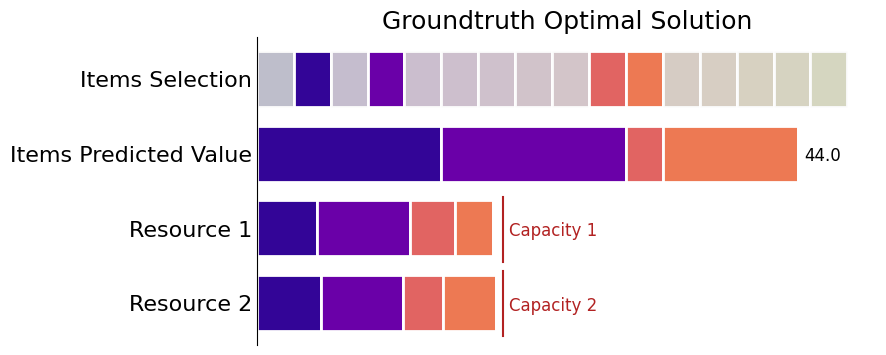

In [16]:
visSol(loader_test, optmodel, ind=ind, pytorch_model=None, method_name=None)

### 2.2 Two-Stage with Linear Regression

Two-stage method: train with a linear regression

In [17]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Epoch  0,  Loss:  134.8594,  Regret: 33.3152%
Epoch  2,  Loss:  426.0872,  Regret: 13.5736%
Epoch  4,  Loss:    6.2839,  Regret: 10.1440%
Epoch  6,  Loss:   11.3960,  Regret:  8.5439%
Epoch  8,  Loss:   23.9876,  Regret:  7.5778%
Epoch 10,  Loss:   33.1396,  Regret:  6.8593%
Epoch 12,  Loss:   14.3398,  Regret:  7.0102%
Epoch 14,  Loss:   82.4736,  Regret:  7.5989%
Epoch 16,  Loss:    7.7356,  Regret:  8.0518%
Epoch 18,  Loss:    7.5153,  Regret:  8.2088%
Epoch 20,  Loss:    8.3157,  Regret:  8.6617%
Epoch 22,  Loss:   74.6368,  Regret:  8.9183%
Epoch 24,  Loss:    8.6579,  Regret:  9.5130%
Epoch 26,  Loss:    8.4490,  Regret:  9.7002%
Epoch 28,  Loss:    9.0721,  Regret:  9.8391%
Epoch 30,  Loss:    8.7236,  Regret: 10.5516%
Epoch 32,  Loss:   12.2261,  Regret: 10.4338%
Epoch 34,  Loss:   11.6751,  Regret: 10.3855%
Epoch 36,  Loss:   25.5984,  Regret: 10.2919%
Epoch 38,  Loss:   18.8297,  Regret: 10.5455%


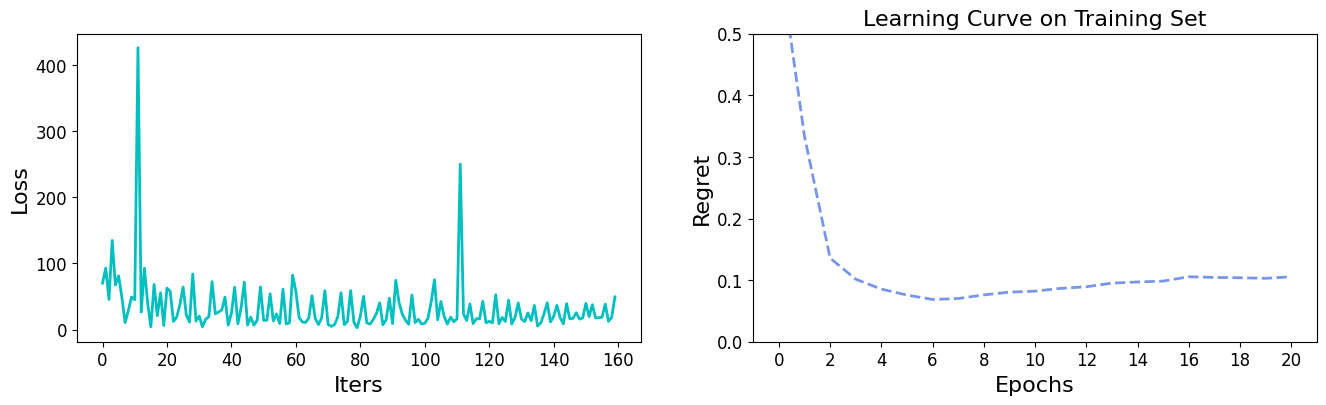

In [18]:
# init MSE loss
mse = nn.MSELoss()
# train
trainModel(reg, loss_func=mse, method_name="2s")

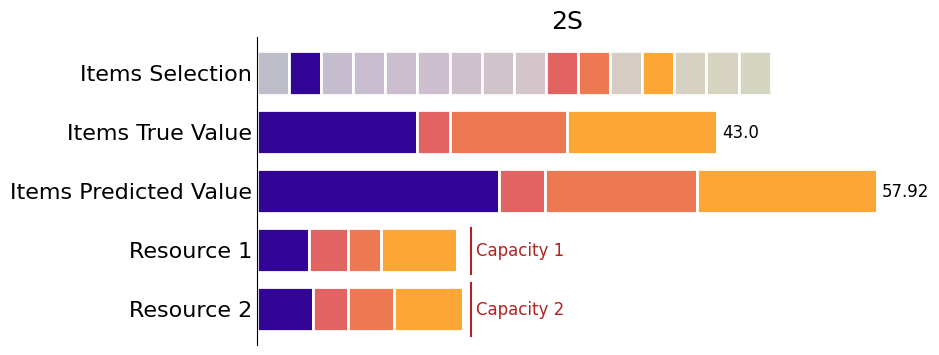

In [19]:
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="2S")

### 2.3 Surrogate Loss

#### 2.3.1 SPO+

Smart Predict-then-Optmize+ Loss

In [20]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:   68.8291,  Regret: 14.1654%
Epoch  2,  Loss:    7.2017,  Regret:  7.5054%
Epoch  4,  Loss:   23.9046,  Regret:  7.1582%
Epoch  6,  Loss:    7.5329,  Regret:  6.7295%
Epoch  8,  Loss:    5.4387,  Regret:  6.5755%
Epoch 10,  Loss:    9.4097,  Regret:  6.4457%
Epoch 12,  Loss:   13.0226,  Regret:  5.9898%
Epoch 14,  Loss:    6.9788,  Regret:  6.0683%
Epoch 16,  Loss:    3.1033,  Regret:  6.0230%
Epoch 18,  Loss:   10.1167,  Regret:  6.0230%
Epoch 20,  Loss:    2.1611,  Regret:  6.0109%
Epoch 22,  Loss:   11.9983,  Regret:  6.1740%
Epoch 24,  Loss:    2.7352,  Regret:  6.0804%
Epoch 26,  Loss:   12.0269,  Regret:  6.1860%
Epoch 28,  Loss:    8.8394,  Regret:  6.0109%
Epoch 30,  Loss:    1.4280,  Regret:  5.9898%
Epoch 32,  Loss:    5.8524,  Regret:  6.0230%
Epoch 34,  Loss:    8.0610,  Regret:  6.3883%
Epoch 36,  Loss:   18.5781,  Regret:  6.5725%
Epoch 38,  Loss:    2.7615,  Regret:  6.2675%


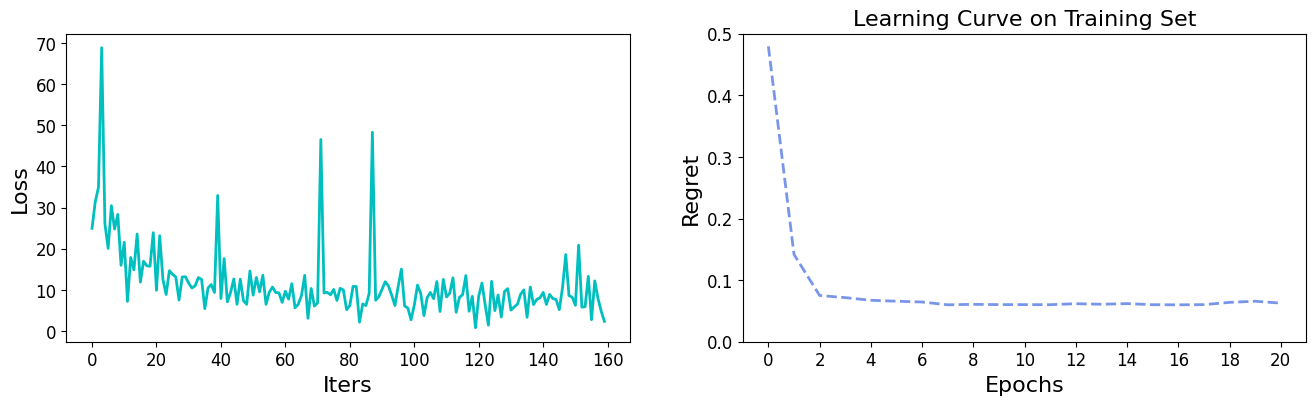

In [21]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=1)
# train
trainModel(reg, loss_func=spop, method_name="spo+")

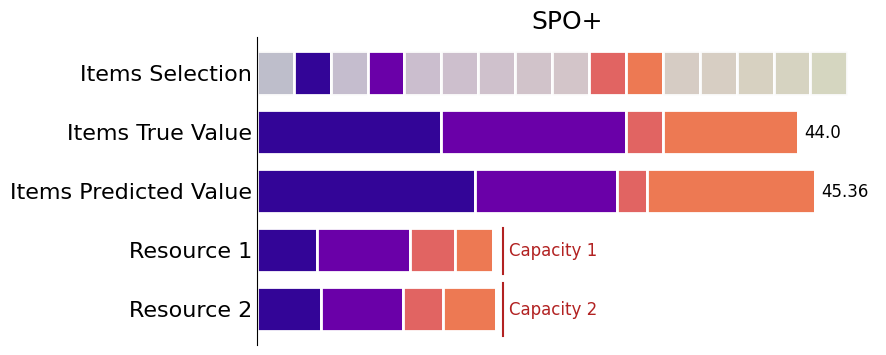

In [22]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="SPO+")

#### 2.3.2 PG

Perturbation Gradient Loss

In [23]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:   -4.8759,  Regret: 49.3434%
Epoch  2,  Loss:   -5.3669,  Regret: 44.6155%
Epoch  4,  Loss:  -12.9970,  Regret: 39.9300%
Epoch  6,  Loss:  -13.4847,  Regret: 36.2346%
Epoch  8,  Loss:   -7.2888,  Regret: 32.6420%
Epoch 10,  Loss:  -17.0586,  Regret: 29.5112%
Epoch 12,  Loss:  -11.6949,  Regret: 26.9239%
Epoch 14,  Loss:  -20.5075,  Regret: 24.8498%
Epoch 16,  Loss:  -25.3725,  Regret: 23.0414%
Epoch 18,  Loss:  -40.7956,  Regret: 21.8760%
Epoch 20,  Loss:  -14.6756,  Regret: 21.1243%
Epoch 22,  Loss:  -20.6964,  Regret: 20.4994%
Epoch 24,  Loss:  -14.9790,  Regret: 20.0857%
Epoch 26,  Loss:  -11.2500,  Regret: 19.6480%
Epoch 28,  Loss:  -14.6419,  Regret: 19.2887%
Epoch 30,  Loss:  -37.2829,  Regret: 19.2857%
Epoch 32,  Loss:  -22.8383,  Regret: 19.2555%
Epoch 34,  Loss:  -15.5000,  Regret: 19.0532%
Epoch 36,  Loss:  -40.2343,  Regret: 19.0895%
Epoch 38,  Loss:  -32.8074,  Regret: 18.9717%


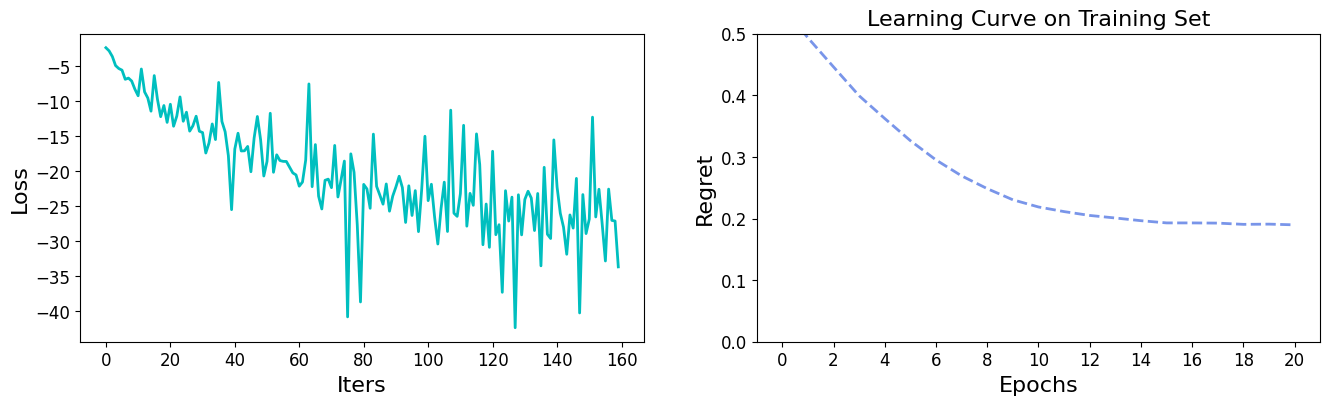

In [24]:
# init SPO+ loss
pg = pyepo.func.perturbationGradient(optmodel, sigma=1.0, two_sides=False, processes=1)
# train
trainModel(reg, loss_func=pg, method_name="pg")

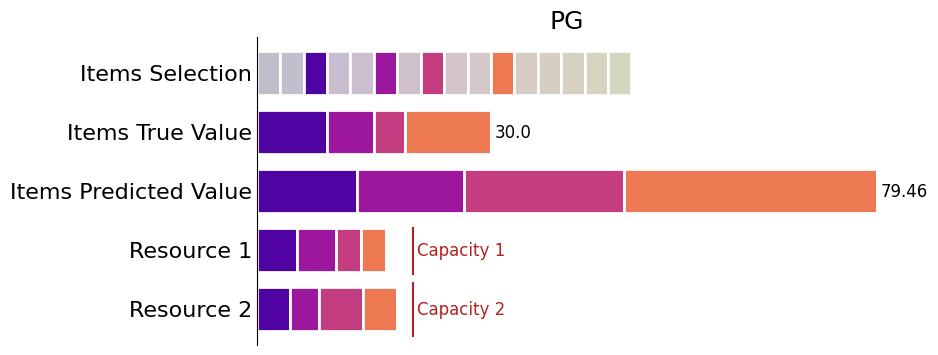

In [25]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="PG")

### 2.4 Perturbed Methods

#### 2.4.1  PFYL

Fenchel-Young Loss with Perturbation

In [26]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:    2.6350,  Regret: 14.9564%
Epoch  2,  Loss:    0.9200,  Regret:  9.7334%
Epoch  4,  Loss:    2.2075,  Regret:  8.9424%
Epoch  6,  Loss:    1.4900,  Regret:  8.5681%
Epoch  8,  Loss:    1.0900,  Regret:  8.3296%
Epoch 10,  Loss:    1.4400,  Regret:  8.6103%
Epoch 12,  Loss:    1.1425,  Regret:  7.2910%
Epoch 14,  Loss:    1.1600,  Regret:  7.3816%
Epoch 16,  Loss:    1.4800,  Regret:  8.2631%
Epoch 18,  Loss:    1.2200,  Regret:  9.4738%
Epoch 20,  Loss:    0.9075,  Regret:  9.8572%
Epoch 22,  Loss:    1.0500,  Regret:  8.0277%
Epoch 24,  Loss:    1.3475,  Regret:  7.9824%
Epoch 26,  Loss:    1.2675,  Regret:  8.1454%
Epoch 28,  Loss:    0.7700,  Regret:  8.5198%
Epoch 30,  Loss:    1.2900,  Regret:  8.0699%
Epoch 32,  Loss:    1.4775,  Regret:  6.5332%
Epoch 34,  Loss:    0.5700,  Regret:  7.8133%
Epoch 36,  Loss:    1.2250,  Regret:  8.1484%
Epoch 38,  Loss:    1.2950,  Regret:  8.3145%


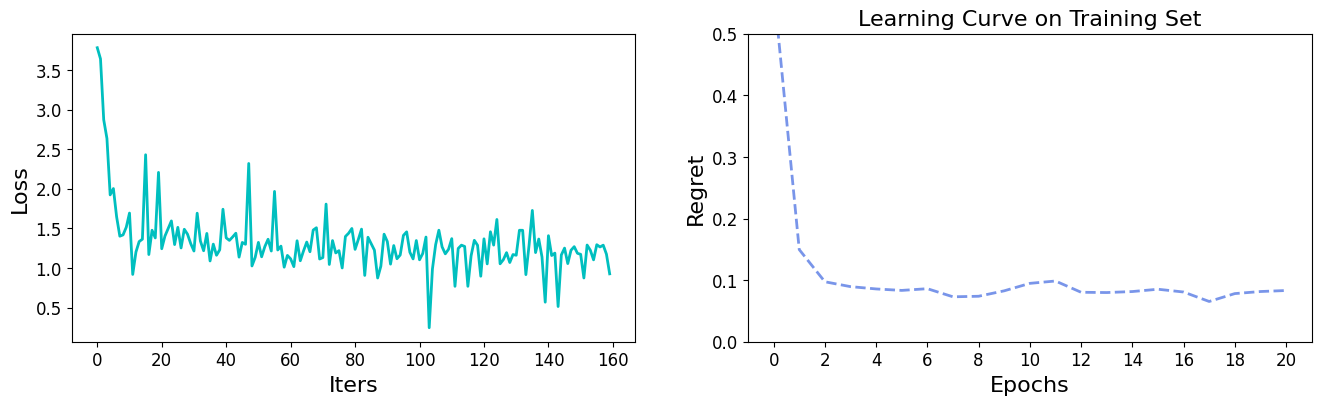

In [27]:
# init pfy loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=1)
# train
trainModel(reg, loss_func=pfy, method_name="pfy")

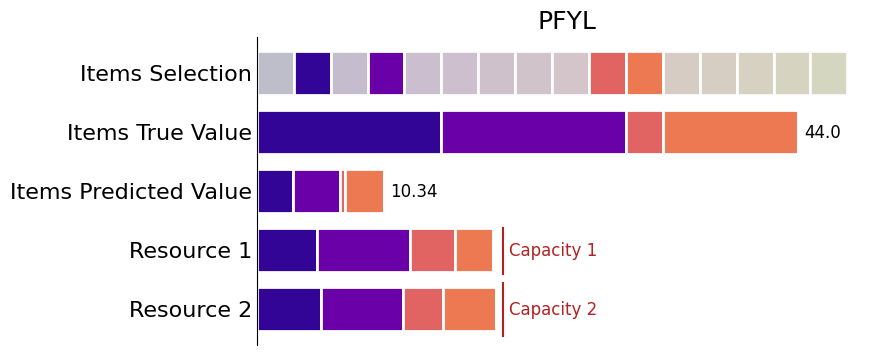

In [28]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="PFYL")

#### 2.4.2 DPO

Differentable Perturbated Optimizer with Regret Loss

In [29]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:    0.3078,  Regret: 34.2390%
Epoch  2,  Loss:    0.2828,  Regret: 24.1826%
Epoch  4,  Loss:    0.1516,  Regret: 21.6979%
Epoch  6,  Loss:    0.1656,  Regret: 19.3461%
Epoch  8,  Loss:    0.1844,  Regret: 17.2478%
Epoch 10,  Loss:    0.0938,  Regret: 14.7813%
Epoch 12,  Loss:    0.2328,  Regret: 13.6280%
Epoch 14,  Loss:    0.0875,  Regret: 14.0265%
Epoch 16,  Loss:    0.1844,  Regret: 14.5035%
Epoch 18,  Loss:    0.1375,  Regret: 14.8658%
Epoch 20,  Loss:    0.1641,  Regret: 15.1043%
Epoch 22,  Loss:    0.1203,  Regret: 14.4129%
Epoch 24,  Loss:    0.2156,  Regret: 14.0778%
Epoch 26,  Loss:    0.1641,  Regret: 14.7269%
Epoch 28,  Loss:    0.1719,  Regret: 15.5481%
Epoch 30,  Loss:    0.1031,  Regret: 15.2221%
Epoch 32,  Loss:    0.1922,  Regret: 15.4515%
Epoch 34,  Loss:    0.1016,  Regret: 15.5270%
Epoch 36,  Loss:    0.0938,  Regret: 13.9359%
Epoch 38,  Loss:    0.2031,  Regret: 13.5102%


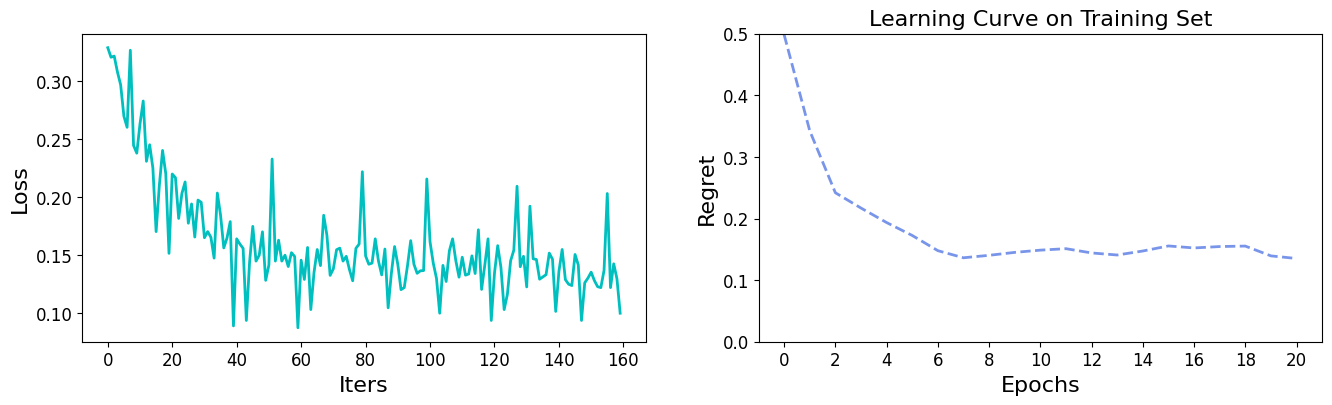

In [30]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=10, sigma=0.5, processes=1)
# set loss
l1 = nn.L1Loss()

# loss function
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

# train
trainModel(reg, loss_func=ptbl1, method_name="ptb")

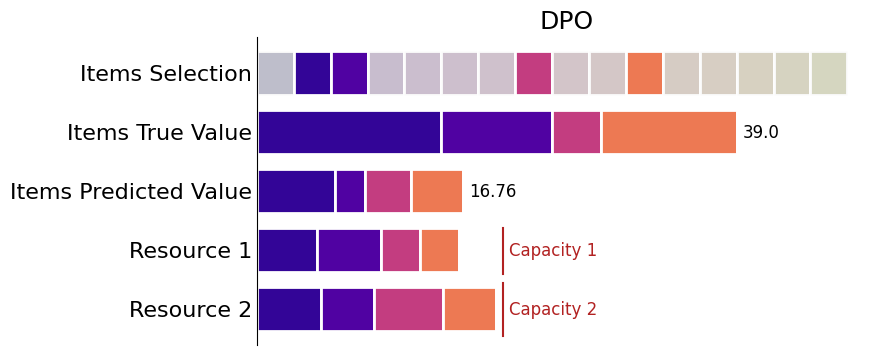

In [31]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="DPO")

#### 2.4.3 I-MLE

Implicit Maximum Likelihood Estimator

In [32]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 2
Epoch  0,  Loss:    0.2375,  Regret: 43.4230%
Epoch  2,  Loss:    0.2094,  Regret: 32.4216%
Epoch  4,  Loss:    0.2078,  Regret: 26.3623%
Epoch  6,  Loss:    0.1938,  Regret: 24.1796%
Epoch  8,  Loss:    0.1594,  Regret: 22.8512%
Epoch 10,  Loss:    0.1359,  Regret: 21.2269%
Epoch 12,  Loss:    0.1000,  Regret: 20.4752%
Epoch 14,  Loss:    0.1719,  Regret: 19.3974%
Epoch 16,  Loss:    0.1734,  Regret: 17.4894%
Epoch 18,  Loss:    0.1734,  Regret: 16.9912%
Epoch 20,  Loss:    0.1500,  Regret: 16.3059%
Epoch 22,  Loss:    0.1313,  Regret: 16.0251%
Epoch 24,  Loss:    0.1844,  Regret: 14.5730%
Epoch 26,  Loss:    0.1281,  Regret: 14.0839%
Epoch 28,  Loss:    0.1859,  Regret: 13.4136%
Epoch 30,  Loss:    0.1781,  Regret: 12.7525%
Epoch 32,  Loss:    0.1406,  Regret: 13.5827%
Epoch 34,  Loss:    0.2219,  Regret: 14.5277%
Epoch 36,  Loss:    0.1094,  Regret: 14.7662%
Epoch 38,  Loss:    0.1250,  Regret: 15.6659%


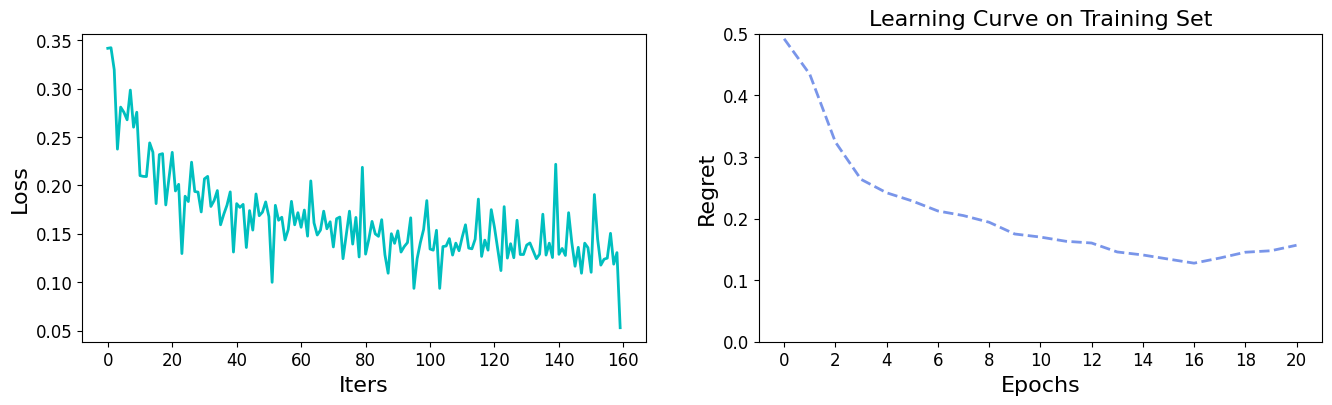

In [33]:
# init imle solver
imle = pyepo.func.implicitMLE(optmodel, n_samples=10, sigma=1.0, lambd=10, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def imlel1(cp, w):
    # perturbed optimizer
    we = imle(cp)
    # loss
    loss = l1(we, w)
    return loss

# train
trainModel(reg, loss_func=imlel1, method_name="imle")

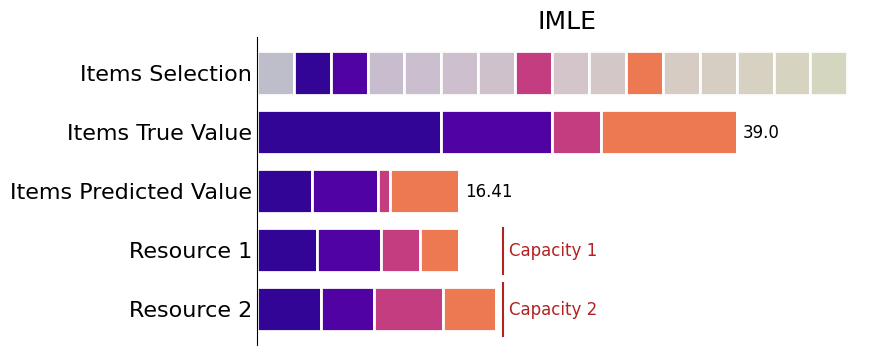

In [34]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="IMLE")

### 2.5 Black-Box Methods

#### 2.5.1 DBB

Differentiable Black-Box with Regret Loss

In [35]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:    5.2500,  Regret: 52.3443%
Epoch  2,  Loss:   64.0000,  Regret: 43.1785%
Epoch  4,  Loss:    5.7500,  Regret: 36.8747%
Epoch  6,  Loss:    7.0000,  Regret: 31.9053%
Epoch  8,  Loss:   16.0000,  Regret: 27.1594%
Epoch 10,  Loss:    6.2500,  Regret: 24.5630%
Epoch 12,  Loss:    3.5000,  Regret: 22.0844%
Epoch 14,  Loss:    3.7500,  Regret: 19.6208%
Epoch 16,  Loss:    8.0000,  Regret: 18.5823%
Epoch 18,  Loss:    5.5000,  Regret: 17.6675%
Epoch 20,  Loss:    2.7500,  Regret: 16.8916%
Epoch 22,  Loss:    1.2500,  Regret: 16.4116%
Epoch 24,  Loss:   14.0000,  Regret: 16.0010%
Epoch 26,  Loss:    1.2500,  Regret: 15.9255%
Epoch 28,  Loss:    1.7500,  Regret: 15.8893%
Epoch 30,  Loss:    1.5000,  Regret: 15.7655%
Epoch 32,  Loss:    0.2500,  Regret: 15.4123%
Epoch 34,  Loss:    5.2500,  Regret: 15.2975%
Epoch 36,  Loss:    3.0000,  Regret: 15.0651%
Epoch 38,  Loss:    4.2500,  Regret: 15.1737%


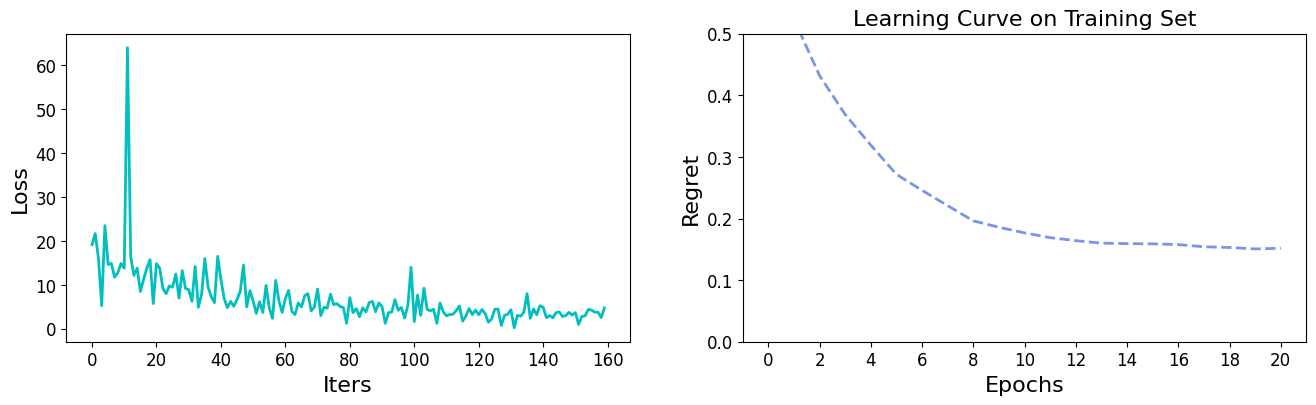

In [36]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=1)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

trainModel(reg, loss_func=dbbl1, method_name="dbb")

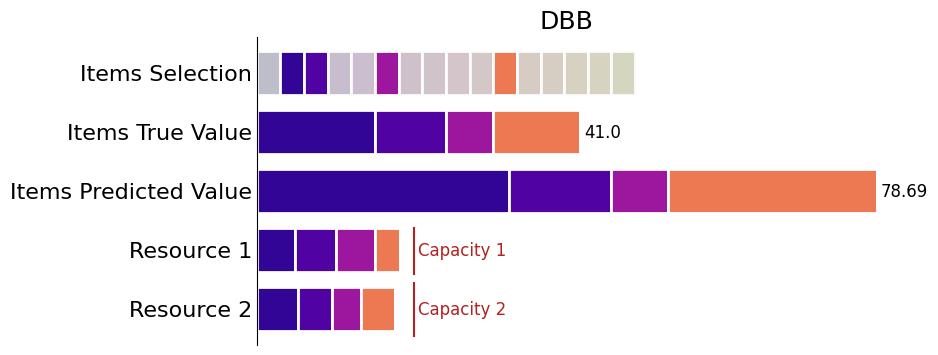

In [37]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="DBB")

#### 2.5.2 NID

Negative Identity Backpropagation with Regret

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 2
Epoch  0,  Loss:    7.2500,  Regret: 30.2479%
Epoch  2,  Loss:    4.2500,  Regret: 19.8020%
Epoch  4,  Loss:    4.5000,  Regret: 17.1150%
Epoch  6,  Loss:   10.7500,  Regret: 16.3844%
Epoch  8,  Loss:    3.5000,  Regret: 15.7776%
Epoch 10,  Loss:    3.5000,  Regret: 15.3851%
Epoch 12,  Loss:    3.0000,  Regret: 14.4643%
Epoch 14,  Loss:    7.0000,  Regret: 13.6461%
Epoch 16,  Loss:    3.0000,  Regret: 13.0121%
Epoch 18,  Loss:    3.2500,  Regret: 12.9396%
Epoch 20,  Loss:    0.5000,  Regret: 12.8913%
Epoch 22,  Loss:    1.0000,  Regret: 12.8672%
Epoch 24,  Loss:    0.2500,  Regret: 12.8249%
Epoch 26,  Loss:    1.0000,  Regret: 12.9125%
Epoch 28,  Loss:    5.0000,  Regret: 13.0061%
Epoch 30,  Loss:    5.5000,  Regret: 13.0453%
Epoch 32,  Loss:    1.5000,  Regret: 12.9246%
Epoch 34,  Loss:    2.7500,  Regret: 12.7374%
Epoch 36,  Loss:    1.2500,  Regret: 12.7917%
Epoch 38,  Loss:   10.0000,  Regret: 12.8430%


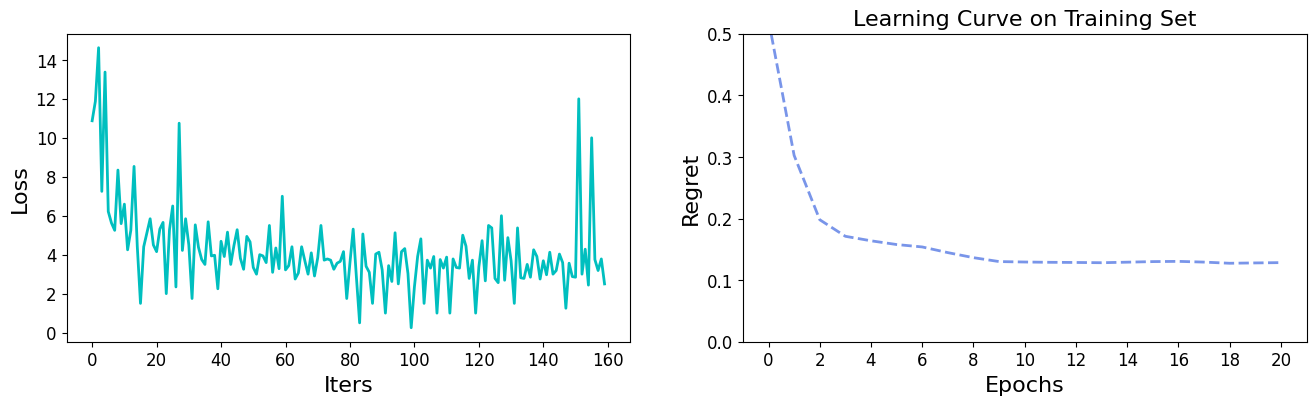

In [39]:
# init dbb solver
nid = pyepo.func.negativeIdentity(optmodel, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def nidl1(cp, c, z):
    # black-box optimizer
    wp = nid(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

trainModel(reg, loss_func=nidl1, method_name="nid")

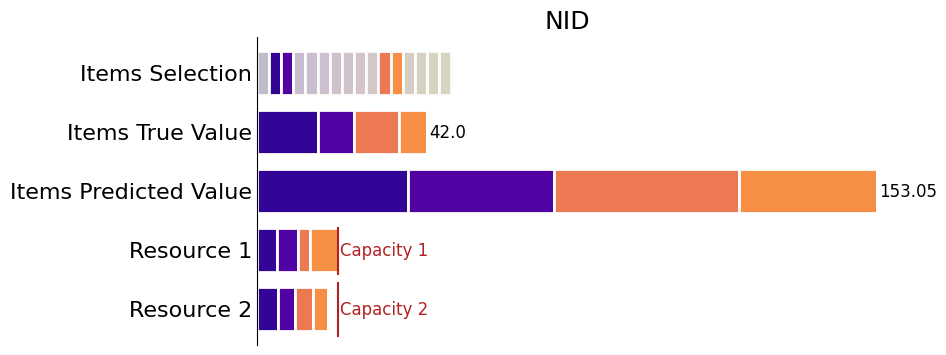

In [40]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="NID")

### 2.6 Contrastive & Ranking Method

#### 2.6.1 NCE

Negative Constrastive Estimation

In [41]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:   -1.5023,  Regret: 23.0776%
Epoch  2,  Loss:   -5.8522,  Regret: 10.8716%
Epoch  4,  Loss:  -13.6350,  Regret:  8.8428%
Epoch  6,  Loss:  -13.3877,  Regret:  8.4322%
Epoch  8,  Loss:  -15.6367,  Regret:  8.2209%
Epoch 10,  Loss:  -23.8275,  Regret:  8.0065%
Epoch 12,  Loss:  -36.4635,  Regret:  7.5657%
Epoch 14,  Loss:  -31.9457,  Regret:  7.3967%
Epoch 16,  Loss:  -32.1586,  Regret:  7.2216%
Epoch 18,  Loss:  -40.4044,  Regret:  7.2578%
Epoch 20,  Loss:  -46.8556,  Regret:  7.1401%
Epoch 22,  Loss:  -42.0664,  Regret:  6.9861%
Epoch 24,  Loss:  -65.8783,  Regret:  6.9348%
Epoch 26,  Loss:  -57.9435,  Regret:  6.8049%
Epoch 28,  Loss:  -64.0504,  Regret:  6.8200%
Epoch 30,  Loss:  -76.7200,  Regret:  6.8321%
Epoch 32,  Loss:  -71.3510,  Regret:  6.9015%
Epoch 34,  Loss:  -74.4083,  Regret:  6.9559%
Epoch 36,  Loss:  -99.0707,  Regret:  6.8472%
Epoch 38,  Loss:  -81.3857,  Regret:  6.7536%


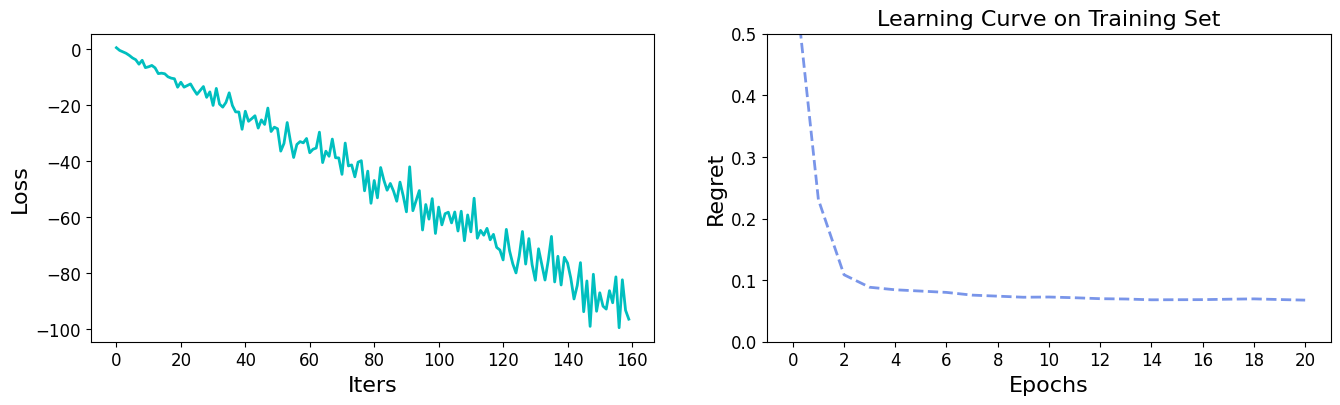

In [42]:
# init nce loss
nce = pyepo.func.NCE(optmodel, processes=1, solve_ratio=0.10, dataset=dataset_train)
# train
trainModel(reg, loss_func=nce, method_name="nce")

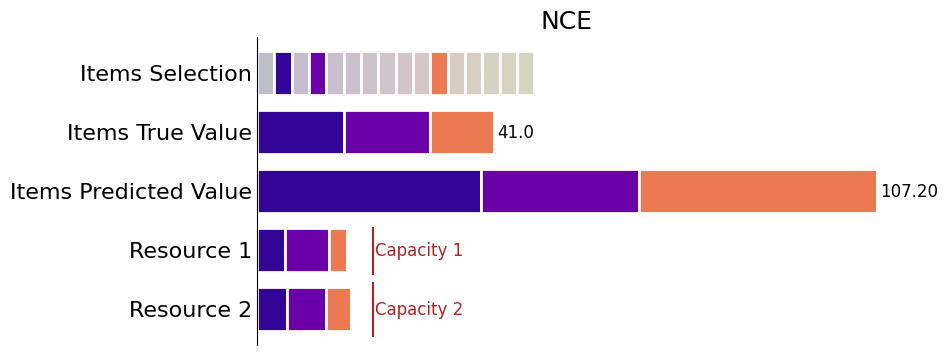

In [43]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="NCE")

#### 2.6.2 LTR

Listwise Learning to Rank

In [44]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

Num of cores: 1
Epoch  0,  Loss:    0.0506,  Regret: 19.2163%
Epoch  2,  Loss:    0.0210,  Regret: 12.9608%
Epoch  4,  Loss:    0.0397,  Regret: 13.3865%
Epoch  6,  Loss:    0.0396,  Regret: 15.3277%
Epoch  8,  Loss:    0.0316,  Regret: 16.2093%
Epoch 10,  Loss:    0.0316,  Regret: 15.8621%
Epoch 12,  Loss:    0.0289,  Regret: 15.3700%
Epoch 14,  Loss:    0.0337,  Regret: 15.3489%
Epoch 16,  Loss:    0.0283,  Regret: 14.7722%
Epoch 18,  Loss:    0.0267,  Regret: 14.0537%
Epoch 20,  Loss:    0.0261,  Regret: 13.8695%
Epoch 22,  Loss:    0.0365,  Regret: 12.5864%
Epoch 24,  Loss:    0.0351,  Regret: 12.3932%
Epoch 26,  Loss:    0.0219,  Regret: 12.2573%
Epoch 28,  Loss:    0.0138,  Regret: 11.9343%
Epoch 30,  Loss:    0.0330,  Regret: 13.1087%
Epoch 32,  Loss:    0.0269,  Regret: 14.1110%
Epoch 34,  Loss:    0.0295,  Regret: 13.6008%
Epoch 36,  Loss:    0.0371,  Regret: 13.3261%
Epoch 38,  Loss:    0.0298,  Regret: 12.5985%


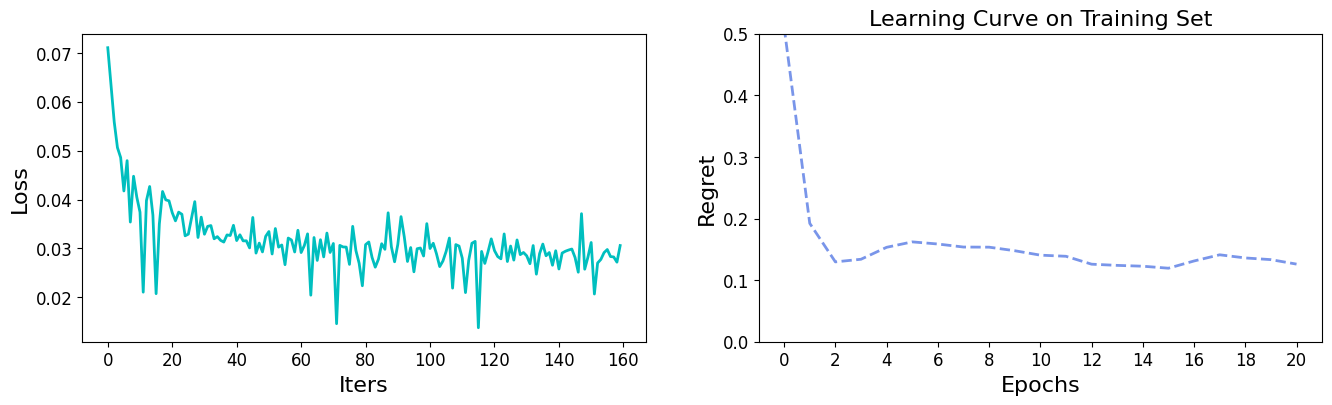

In [45]:
# init ltr loss
ltr = pyepo.func.listwiseLTR(optmodel, processes=1, solve_ratio=0.10, dataset=dataset_train)
# train
trainModel(reg, loss_func=ltr, method_name="ltr")

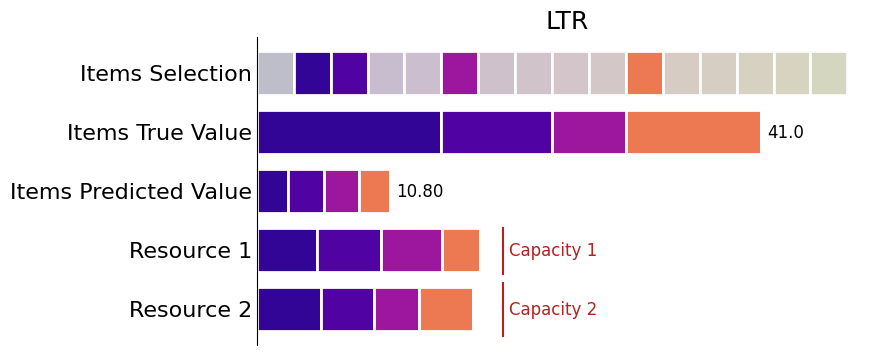

In [46]:
# compare solutions
visSol(loader_test, optmodel, ind, pytorch_model=reg, method_name="LTR")